In [1]:
# import libraries
import numpy as np
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from sklearn.model_selection import train_test_split
from torchinfo import summary
from contextlib import redirect_stdout

from model.fcae import createLevel7Net20x20, createLevel7Net30x30, createLevel9Net, createLevel8Net, createLevel6Net

from lib.evaluate import evaluate_total_predictions_set, display_mazes

%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load data
path_to_data = "./data/"

data_size = (30, 30)

X_file = np.load(f"{path_to_data}100000x{data_size[0]}x{data_size[1]}_unsolved.npy")
Y_file = np.load(f"{path_to_data}100000x{data_size[0]}x{data_size[1]}_solved.npy")

X_file = (X_file - X_file.min() ) / ( X_file.max() - X_file.min())
Y_file = Y_file

# x_tensor = torch.tensor(X_norm, dtype=torch.float32, device=device)
# y_tensor = torch.tensor(Y_norm, dtype=torch.float32, device=device)

# dataset = TensorDataset(x_tensor, y_tensor)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    X_file, Y_file, test_size=0.2
)

# transform to tensor
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [5]:
def pad_to_size(input_tensor, solution_tensor, target_size=50):
    # Calculate padding for input tensor
    pad_h = target_size - input_tensor.shape[-2]  # Difference in height
    pad_w = target_size - input_tensor.shape[-1]  # Difference in width
    padding = (0, pad_w, 0, pad_h)  # (left, right, top, bottom)
    padded_input = F.pad(input_tensor, padding, mode="constant", value=0)

    # Calculate padding for solution tensor
    pad_h_sol = target_size - solution_tensor.shape[-2]
    pad_w_sol = target_size - solution_tensor.shape[-1]
    padding_sol = (0, pad_w_sol, 0, pad_h_sol)
    padded_solution = F.pad(solution_tensor, padding_sol, mode="constant", value=0)

    return padded_input, padded_solution

In [6]:
# create dataset
x_train_padded, y_train_padded = pad_to_size(x_train, y_train, data_size[0])
x_test_padded, y_test_padded = pad_to_size(x_test, y_test, data_size[0])

train_dataset = TensorDataset(x_train_padded, y_train_padded)
test_dataset = TensorDataset(x_test_padded, y_test_padded)

batchsize    = 64
train_loader = DataLoader(
    train_dataset, batch_size=batchsize, shuffle=True, drop_last=True
)
test_loader = DataLoader(test_dataset, batch_size=batchsize)

In [8]:
# Test Lazy Loading
for x_batch, y_batch in train_loader:
    print("Batch X Shape:", x_batch.shape)
    print("Batch Y Shape:", y_batch.shape)
    break

Batch X Shape: torch.Size([64, 1, 30, 30])
Batch Y Shape: torch.Size([64, 1, 30, 30])


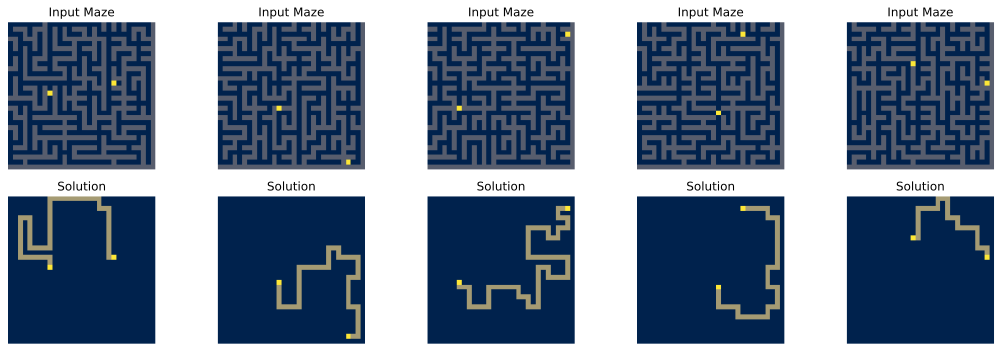

In [ ]:
# Plot example mazes
def plot_mazes(x_batch, y_batch, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(x_batch[i, 0].cpu().numpy(), cmap="cividis")
        plt.title("Input Maze")
        plt.axis("off")

        plt.subplot(2, n, i + 1 + n)
        plt.imshow(y_batch[i, 0].cpu().numpy(), cmap="cividis")
        plt.title("Solution")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Beispielplot
plot_mazes(x_batch, y_batch)

In [ ]:
channel_configuration = (32, 32, 64, 128, 128, 256, 256)

In [ ]:
def trainNet(num_epochs=20, print_time=True, channels=channel_configuration):
    net, criterion, optimizer = createLevel8Net(channels=channels)

    net.to(device)

    train_loss = torch.zeros(num_epochs)
    test_loss = torch.zeros(num_epochs)

    start_time = time.time()
    runtimes = []

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        net.train()
        batch_loss = []

        for X, y in train_loader:

            X = X.to(device)
            y = y.to(device)

            y_hat = net(X)
            loss = criterion(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())

        train_loss[epoch] = np.mean(batch_loss)

        net.eval()
        batch_loss = []
        
        with torch.no_grad():
            for X, y in test_loader:

                # push data to GPU
                X = X.to(device)
                y = y.to(device)

                # forward pass and loss
                y_hat = net(X)
                loss = criterion(y_hat, y)

                # loss and accuracy from this batch
                batch_loss.append(loss.item())

        test_loss[epoch] = np.mean(batch_loss)


        epoch_end_time = time.time()
        runtime = epoch_end_time - epoch_start_time
        runtimes.append(epoch_end_time - epoch_start_time)

        if print_time:
            print(
                f"Epoch {epoch+1} took {runtime:.1f} seconds. Total: {(epoch_end_time - start_time) / 60:.1f} minutes. Remaining: {((sum(runtimes[-20:]) / len(runtimes[-20:])) * (num_epochs - epoch)) / 60:.2f} minutes. Loss: {train_loss[epoch]:.6f}"
            )

    return train_loss, test_loss, net

In [12]:
num_epochs = 100
train_loss, test_loss, net = trainNet(num_epochs, channels=channel_configuration)


KeyboardInterrupt



In [13]:
os.makedirs("./archive/temp/", exist_ok=True)
torch.save(net.state_dict(), f"./archive/temp/net.pt")

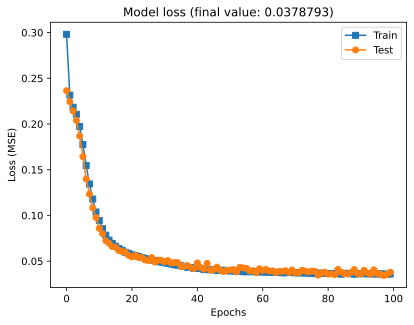

In [14]:
plt.plot(train_loss, "s-", label="Train")
plt.plot(test_loss, "o-", label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Model loss (final value: %g)" % test_loss[-1])
plt.legend()

plt.savefig("./archive/temp/loss.png", bbox_inches="tight")
plt.show()

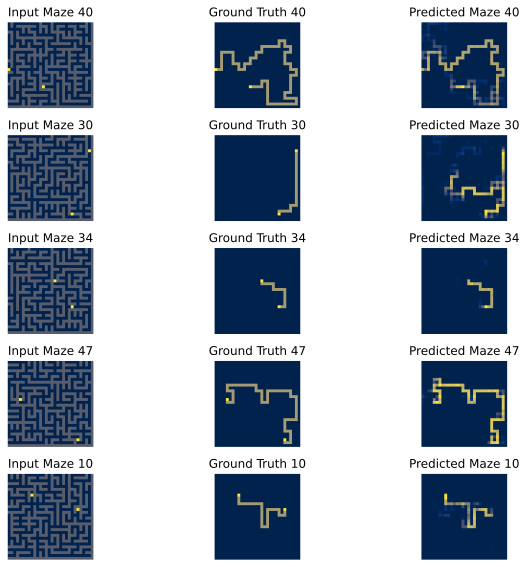

In [ ]:
X, y = next(iter(test_loader))


net = net.to("cpu")
X = X.cpu()
y = y.cpu()

y_hat = net(X)

num_samples = 5

fig, axes = plt.subplots(num_samples, 3, figsize=(10, 8))

i = 0
for n in list(np.random.randint(0, y_hat.shape[0], 5)):
    # Original data (input)
    axes[i, 0].imshow(X[n, 0].detach().cpu().numpy(), cmap="cividis")
    axes[i, 0].set_title(f"Input Maze {n+1}")
    axes[i, 0].axis("off")

    # Ground truth label
    axes[i, 1].imshow(y[n, 0].detach().cpu().numpy(), cmap="cividis")
    axes[i, 1].set_title(f"Ground Truth {n+1}")
    axes[i, 1].axis("off")

    # Predicted label (output from the network)
    axes[i, 2].imshow(y_hat[n, 0].detach().cpu().numpy(), cmap="cividis")
    axes[i, 2].set_title(f"Predicted Maze {n+1}")
    axes[i, 2].axis("off")
    i += 1

# Adjust layout
plt.tight_layout()
plt.savefig("./archive/temp/input_truth_prediction.png", bbox_inches="tight")
plt.show()